In [1]:
# Required libraries
import pandas as pd
import csv
import sys
from collections import Counter
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
import preprocessor as p
from ekphrasis.classes.segmenter import Segmenter
nltk.download
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud
import wandb
from wandb.keras import WandbCallback
import numpy as np
from keras.preprocessing import text
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import random
import pickle
import time

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jack\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Jack\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Importing data
data1 = pd.read_csv("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\Data\\hashtag_donaldtrump.csv")
data2 = pd.read_csv("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\Data\\hashtag_joebiden.csv")

data = data1.append(data2, ignore_index=True)
# Removing irrelevant columns
data.drop(data.columns[[1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]], axis=1, inplace=True)

#converting all tweets to strings
data['tweet']=data['tweet'].apply(str)

C:\Users\Jack\AppData\Local\Temp\ipykernel_13968\486808917.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\Data\\hashtag_joebiden.csv")
C:\Users\Jack\AppData\Local\Temp\ipykernel_13968\486808917.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data1.append(data2, ignore_index=True)


In [3]:
# function for replacing URLs and mentions with placeholders
def preprocess(text):
    preprocessed_text = []
    for t in text.split():
        if len(t) > 1:
            t = '@user' if t[0] == '@' and t.count('@') == 1 else t
            t = 'http' if t.startswith('http') else t
            t = 'http' if t.startswith('www') else t
        preprocessed_text.append(t)
    return ' '.join(preprocessed_text)

In [4]:
# applying preprocessing function to data
Cleaned_Tweet =[]
for tweet in data["tweet"]:
    Cleaned_Tweet.append(preprocess(tweet))
data["Cleaned_Tweet"] = Cleaned_Tweet

In [5]:
# loading model & creating lables
roberta = "cardiffnlp/twitter-roberta-base-sentiment-latest"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
lables = ['Negative', 'Neutral', 'Positive']
dates = ["15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","31","01","02","03","04","05","06","07","08"]


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


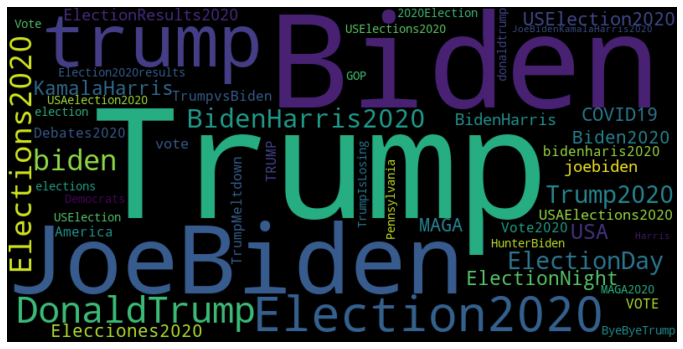

In [6]:
#Creating new column with hashtags contained in tweet
data['hashtag'] = data['tweet'].apply(lambda x: re.findall(r"#(\w+)", x))
# creating list of all hashtags used
hashtags = []
for i in data['hashtag']:
    hashtags.append(i)

flat_list = [item for sublist in hashtags for item in sublist]  
#Frequency of words
fdist = FreqDist(flat_list)
#WordCloud from hashtags
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
# 100 most common hashtags
c=Counter(flat_list)
print(c.most_common(100))

[('Trump', 857174), ('Biden', 582728), ('JoeBiden', 321451), ('trump', 176908), ('Election2020', 168201), ('DonaldTrump', 158634), ('Elections2020', 102336), ('biden', 89674), ('BidenHarris2020', 76445), ('Trump2020', 64862), ('ElectionDay', 64235), ('USA', 47225), ('KamalaHarris', 38998), ('ElectionNight', 38684), ('MAGA', 36306), ('COVID19', 36043), ('USElection2020', 35960), ('Biden2020', 31702), ('Elecciones2020', 31483), ('ElectionResults2020', 29097), ('joebiden', 28566), ('BidenHarris', 28190), ('USAElections2020', 27861), ('vote', 27578), ('VOTE', 25926), ('TRUMP', 25807), ('America', 24800), ('Debates2020', 24305), ('TrumpMeltdown', 23687), ('bidenharis2020', 22728), ('TrumpvsBiden', 21686), ('Vote2020', 21026), ('Election2020results', 20634), ('USAelection2020', 19420), ('USElections2020', 19395), ('elections', 18640), ('Democrats', 18188), ('election', 17627), ('GOP', 17501), ('Vote', 17367), ('Pennsylvania', 16476), ('USElection', 16359), ('donaldtrump', 15717), ('2020Elect

In [8]:
# Important note: different hashtags that have same meaning will be assumed to be the same (e.g Trump, trump, DonaldTrump)
# Topics to be used: 
# 1. Trump  2. Biden  3. Elections2020 4. KamalaHarris 5. MAGA 6. COVID19 7. TrumpMeltdown 
# 8. Democrats 9. GOP 10. Pennsylvania 11. Obama 12. Michigan 13. VoteHimOut* 14. CNN 15. Republicans 16. Georgia
# 17. China 18. FoxNews 19. Pence 20. TrumpIsLosing

# Removing any characters that can break model
def remove_non_ascii(string):
    return string.encode('ascii', errors='ignore').decode()

In [9]:
def predict(topic,topicdf):
    # Creating dataframe containing topic related tweets and their creation date        
    topic = []
    topic = pd.DataFrame(topic)
    topic["created"] = created
    topic["tweet"] = tweet

    # Creating new dataframe for Sentiment analysis results sorted by date
    topicdf = []
    topicdf = pd.DataFrame(topicdf)
    for date in dates:
        tweets = []
        for i in range(len(topic["tweet"])):
            if topic["created"][i].startswith(date):
                tweets.append(topic["tweet"][i])
        #Scaling down tweets to only analyse ~10,000 due to computational limits
        random.shuffle(tweets)    
        tweets = tweets[:400]
        encoded_tweets = []
        for i in range(len(tweets)):
            tweetClean = remove_non_ascii(tweets[i]) # removing non ascii characters
            encoded_tweet = tokenizer(tweetClean, return_tensors='pt') # encoding tweet
            encoded_tweets.append(encoded_tweet)
        All_scores = []
        startTime = time.time()
        for i in range(len(tweets)):

            output = model(**encoded_tweets[i]) # executing analysis on tweet
            scores = output[0][0].detach().numpy()
            scores = softmax(scores)
            All_scores.append(scores)

        Results = []

        for i in range(len(All_scores)):
            max_value = np.amax(All_scores[i])        # Attaining sentiment score
            max_label = lables[np.argmax(All_scores[i])]
            Results.append(max_label)
        executionTime = (time.time() - startTime)
        print('Execution time in seconds: ' + str(executionTime)) # measuring execution time
        Neg = Results.count("Negative")
        Neut = Results.count("Neutral")
        Pos = Results.count("Positive")
        values = [Neg,Neut,Pos]
        topicdf[date] = values  # appending data to dataframe
        print(date)
    return topicdf
  

In [15]:
# Aggregating tweets based on hashtag and performing sentiment analysis
# Analysis for Trump related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Trump":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "trump":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "DonaldTrump":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "donaldtrump":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
Trumptotaltweets = predict("Trump","Trumptotaltweets")
# Analysis for Biden related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Biden":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "biden":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "JoeBiden":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "joebiden":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
Bidentotaltweets = predict("Biden","Bidentotaltweets")
# Analysis for Elections2020 related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Elections2020":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "USAElections2020":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "USElections2020":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
Elections2020totaltweets = predict("Elections2020","Elections2020totaltweets")            
# Analysis for KamalaHarris related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "KamalaHarris":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "Harris":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "harris":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
KamalaHarristotaltweets = predict("KamalaHarris","KamalaHarristotaltweets")            
# Analysis for MAGA related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "MAGA":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "MAGA2020":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "maga":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
MAGAtotaltweets = predict("MAGA","MAGAtotaltweets")            
# Analysis for COVID19  related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "COVID19":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "covid19":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "coronavirus":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "Coronavirus":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "COVID":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i]) 
COVIDtotaltweets = predict("COVID","COVIDtotaltweets")
# Analysis for TrumpMeltdown  related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "TrumpMeltdown":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "trumpmeltdown":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])         
TrumpMeltdowntotaltweets = predict("TrumpMeltdown","TrumpMeltdowntotaltweets")
# Analysis for Democrats  related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Democrats":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "democrats":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])                    
Democratstotaltweets = predict("Democrats","Democratstotaltweets")
# Analysis for GOP  related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "GOP":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "GOP2020":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])         
        elif hashtag == "gop":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])         
GOPtotaltweets = predict("GOP","GOPtotaltweets")
# Analysis for Pennsylvania related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Pennsylvania":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "pennsylvania":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
Pennsylvaniatotaltweets = predict("Pennsylvania","Pennsylvaniatotaltweets")
# Analysis for Obama  related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Obama":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "obama":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])            
Obamatotaltweets = predict("Obama","Obamatotaltweets")
# Analysis for Michigan related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Michigan":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "michigan":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i]) 
Michigantotaltweets = predict("Michigan","Michigantotaltweets")            
# Analysis for VoteHimOut related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "VoteHimOut":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "votehimout":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
VoteHimOuttotaltweets = predict("VoteHimOut","VoteHimOuttotaltweets")
# Analysis for CNN related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "CNN":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "cnn":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
CNNtotaltweets = predict("CNN","CNNtotaltweets")            
# Analysis for Republicans related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Republicans":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "republicans":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])            
Republicanstotaltweets = predict("Republicans","Republicanstotaltweets")            
# Analysis for Florida related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Florida":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "florida":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
Floridatotaltweets = predict("Florida","Floridatotaltweets")
# Analysis for Georgia related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Georgia":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "georgia":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
Georgiatotaltweets = predict("Georgia","Georgiatotaltweets")
# Analysis for China related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "China":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "china":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
Chinatotaltweets = predict("China","Chinatotaltweets")
# Analysis for FoxNews related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "FoxNews":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "foxnews":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
FoxNewstotaltweets = predict("FoxNews","FoxNewstotaltweets")
# Analysis for Pence related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "Pence":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "pence":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
Pencetotaltweets = predict("Pence","Pencetotaltweets")
# Analysis for TrumpIsLosing related tweets
created = []
tweet = []
for i in range(len(data["tweet"])):
    for hashtag in data["hashtag"][i]:
        if hashtag == "TrumpIsLosing":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
        elif hashtag == "trumpislosing":
            created.append(data["created_at"][i])
            tweet.append(data["Cleaned_Tweet"][i])
TrumpIsLosingtotaltweets = predict("TrumpIsLosing","TrumpIsLosingtotaltweets")



Execution time in seconds: 2.450226306915283
15
Execution time in seconds: 2.2124853134155273
16
Execution time in seconds: 2.3918185234069824
17
Execution time in seconds: 2.370683431625366
18
Execution time in seconds: 2.3267059326171875
19
Execution time in seconds: 2.5542075634002686
20
Execution time in seconds: 2.6464037895202637
21
Execution time in seconds: 2.2858047485351562
22
Execution time in seconds: 1.887324571609497
23
Execution time in seconds: 2.621277093887329
24
Execution time in seconds: 2.042241096496582
25
Execution time in seconds: 2.482045888900757
26
Execution time in seconds: 1.9877805709838867
27
Execution time in seconds: 2.422598123550415
28
Execution time in seconds: 2.2180309295654297
29
Execution time in seconds: 2.5420897006988525
30
Execution time in seconds: 2.4082043170928955
31
Execution time in seconds: 2.231924057006836
01
Execution time in seconds: 2.404482364654541
02
Execution time in seconds: 2.4833967685699463
03
Execution time in seconds: 2.

KeyboardInterrupt: 

In [ ]:
Topics = [Trumptotaltweets,Bidentotaltweets,Elections2020totaltweets,KamalaHarristotaltweets,MAGAtotaltweets,
          COVIDtotaltweets,TrumpMeltdowntotaltweets,Democratstotaltweets,GOPtotaltweets,Pennsylvaniatotaltweets,
          Obamatotaltweets,Michigantotaltweets,VoteHimOuttotaltweets,CNNtotaltweets,Republicanstotaltweets,
          Floridatotaltweets,Georgiatotaltweets,Chinatotaltweets,FoxNewstotaltweets,Pencetotaltweets,TrumpIsLosingtotaltweets]
#Calculating sentiment score for each topic sorted by date
FinalScores =[]
for topic in Topics:    
    Scores = []
    for date in dates:
        SentiScore = topic[date][2]-topic[date][0]
        SentiScore = SentiScore/(topic[date][2]+topic[date][0]) 
        Scores.append(SentiScore)
    FinalScores.append(Scores)

In [ ]:
#graph plot for Trump tweets
pos=[]
neg=[]
neu=[]
dates2 =[]
for date in dates:
    neg.append(Trumptotaltweets[date][0])
    neu.append(Trumptotaltweets[date][1])
    pos.append(Trumptotaltweets[date][2])
for element in dates:
    dates2.append(int(element))
plt.plot(dates,pos, label = "Positive")
plt.plot(dates,neu, label = "Neutral")
plt.plot(dates,neg, label = "Negative")
plt.title("Sentiment Evolution for Trump Related Tweets")
plt.xlabel("Day of the Month (Oct2020-Nov2020)")
plt.ylabel("Number of Tweets")
plt.legend()

In [ ]:
#Saving data to pickle file
Trumptotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Trump2.pkl")
Bidentotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Biden2.pkl")
Elections2020totaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Elections20202.pkl")
KamalaHarristotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\KamalaHarris2.pkl")
MAGAtotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\MAGA20202.pkl")
COVIDtotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\COVID2.pkl")
TrumpMeltdowntotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\TrumpMeltdown2.pkl")
Democratstotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Democrats2.pkl")
GOPtotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\GOP2.pkl")
Pennsylvaniatotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Pennsylvania2.pkl")
Obamatotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Obama2.pkl")
Michigantotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Michigan2.pkl")
VoteHimOuttotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\VoteHimOut2.pkl")
CNNtotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\CNN2.pkl")
Republicanstotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Republicans2.pkl")
Floridatotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Florida2.pkl")
Georgiatotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Georgia2.pkl")
Chinatotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\China2.pkl")
FoxNewstotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\FoxNews2.pkl")
Pencetotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Pence2.pkl")
TrumpIsLosingtotaltweets.to_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\TrumpIsLosing2.pkl")

In [ ]:
#Loading data
Trumptotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Trump2.pkl")
Bidentotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Biden2.pkl")
Elections2020totaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Elections20202.pkl")
KamalaHarristotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\KamalaHarris2.pkl")
MAGAtotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\MAGA20202.pkl")
COVIDtotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\COVID2.pkl")
TrumpMeltdowntotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\TrumpMeltdown2.pkl")
Democratstotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Democrats2.pkl")
GOPtotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\GOP2.pkl")
Pennsylvaniatotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Pennsylvania2.pkl")
Obamatotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Obama2.pkl")
Michigantotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Michigan2.pkl")
VoteHimOuttotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\VoteHimOut2.pkl")
CNNtotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\CNN2.pkl")
Republicanstotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Republicans2.pkl")
Floridatotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Florida2.pkl")
Georgiatotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Georgia2.pkl")
Chinatotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\China2.pkl")
FoxNewstotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\FoxNews2.pkl")
Pencetotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\Pence2.pkl")
TrumpIsLosingtotaltweets = pd.read_pickle("C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\SentiData\\TrumpIsLosing2.pkl")

In [ ]:
#Aggregating sentiment data
Topicnames = ["Trump","Biden","Elections2020","KamalaHarris","MAGA",
          "COVID","TrumpMeltdown","Democrats","GOP","Pennsylvania",
          "Obama","Michigan","VoteHimOut","CNN","Republicans",
          "Florida","Georgia","China","FoxNews","Pence","TrumpIsLosing"]
SentimentData = pd.DataFrame(FinalScores[0])
for i in range(0,21):
    SentimentData[i] = FinalScores[i]
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in range(0,21):
    int2str = str(index[i])
    SentimentData.rename({index[i]: Topicnames[i]}, axis=1, inplace=True)
SentimentData.rename({21: "TrumpIsLosing"}, axis=1, inplace=True)
    


In [ ]:
SentimentData.to_csv('C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\Data\\SentimentData3.csv', index=False) #saving to csv file for use in R

In [ ]:
# sentiment score plot
plt.plot(dates,Scores)
plt.title("Sentiment Score for Trump Related Tweets")
plt.xlabel("Day of the Month (Oct2020-Nov2020)")
plt.ylabel("Sentiment Score")

In [ ]:
#graph plot for Trump tweets with sentiment score overlaid 
pos=[]
neg=[]
neu=[]
dates2 =[]
for date in dates:
    neg.append(Trumptotaltweets[date][0])
    neu.append(Trumptotaltweets[date][1])
    pos.append(Trumptotaltweets[date][2])
for element in dates:
    dates2.append(int(element))
fig,ax = plt.subplots()
plt.plot(dates,pos,'--', label = "Positive")
plt.plot(dates,neg,'--', label = "Negative", color="green")
plt.title("Sentiment Evolution/Score for Trump Related Tweets")
plt.xlabel("Day of the Month (Oct2020-Nov2020)")
plt.ylabel("Number of Tweets")
plt.legend()
ax2=ax.twinx()
ax2.plot(dates,Scores, label = "Sentiment Score", color="red")
ax2.set_ylabel("Sentiment Score")


In [ ]:
SentimentData # aggregated sentiment data

In [ ]:
percentages = []
for i in range(20):
    count = []
    for hashtag in list1:
        if c[hashtag] <= i:
            count.append(hashtag)
    percentages.append(len(count)*100/285380)
x=[]
for i in range(1,21):
    x.append(i)
        

In [ ]:
# graph plot for unique hashtag usage as a proportion of total hashtag usage
plt.plot(x,percentages)
plt.ylim([0, 100])
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Proportion of Total Hashtags Based on Unique Hashtag Usage")
plt.xlabel("Unique uses of Hashtag")
plt.ylabel("Percentage of Total Unique Hashtags")

In [ ]:
########################################### TweetEval ###########################################

In [ ]:
# Loading testing data from TweetEval + labels
with open('C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\Data\\TweetEvalTest.txt', encoding="utf8") as f:
    TestData = f.readlines()
with open('C:\\Users\\Jack\\Desktop\\Uni Work\\PROJECT\\Data\\TweetEvalTestLabels.txt', encoding="utf8") as f:
    TestLabels = f.readlines()
# Data pre-processing 
TestData_ = []
TestLabels_ = []
for text in TestData:
    TestData_.append(text.replace("\n",""))  
for text in TestLabels:
    text.replace("\n","")
    TestLabels_.append(int(text))
TweetEvalTest = []
TweetEvalTest = pd.DataFrame(TweetEvalTest)      
TweetEvalTest["text"] = TestData_
TweetEvalTest["labels"] = TestLabels_
TweetEvalTest = TweetEvalTest[TweetEvalTest.labels != 1]
Labels = []
for value in TweetEvalTest["labels"]:
    if value == 2:
        Labels.append("Positive")
        
    else:
        Labels.append("Negative")
cleanedTest = []
for text in TweetEvalTest["text"]:
    tweetClean = remove_non_ascii(text)
    cleanedTest.append(tweetClean)



In [ ]:
# performing analysis on TweetEval test data
encoded_tweets = []
for text in cleanedTest:
    encoded_tweet = tokenizer(text, return_tensors='pt')
    encoded_tweets.append(encoded_tweet)
All_scores = []
for i in range(len(cleanedTest)):
    output = model(**encoded_tweets[i])
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    All_scores.append(scores)
    print(i,"/6347")

In [ ]:
Results = []
for i in range(len(All_scores)):
    max_value = np.amax(All_scores[i])   # attaining results
    max_label = lables[np.argmax(All_scores[i])]
    Results.append(max_label)

In [ ]:
print((len([i for i, j in zip(Results, Labels) if i == j]))*100/6347) # printing accuracy